<a href="https://colab.research.google.com/github/jessegrabowski/spartan-stats-tutorial-2025/blob/main/notebooks/03_whence_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**💡 To better engage gray mass we suggest you turn off Colab AI autocompletion in `Tools > Settings > AI Assistance`**

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import graphviz as gr

# Whence Economic Growth?

An important paper in the Economic Growth literature is ["Aid, Policies, and Growth" by Burnside and Dollar (2000, AER)](https://www.aeaweb.org/articles?id=10.1257/aer.90.4.847)

The paper examined the connection between international aid and economic growth in the developing world. Their conclusion was that aid works, but only in countries with "good institutions". Institutional quality was assessed by looking at measures of fiscal, monetary, and trade policy.

In this notebook, we will revisit this paper, keeping an eye on the Bayesian workflow, and the Pearl causal framework.

# Load Data

In [2]:
rename_dict = {
    'Country3':'country',
    'YEAR1':'year',
    'GDPG': 'gdp_growth',
    'GDP': 'initial_gdp_pc',
    'BB': 'budget_surplus',
    'INFL': 'inflation',
    'SACW': 'trade_openness',
    'GOVC': 'gov_consumption_gdp',
    'ETHNF': 'ethnic_fractionalization',
    'ASSAS': 'assassinations_rate',
    'ICRGE': 'institution_quality',
    'M2-1': 'lagged_money_supply',
    'SSA': 'sub_saharan_africa',
    'EASIA': 'east_asia',
    'LPOP': 'log_population',
    'EGYPT': 'egypt_dummy',
    'CENTAM': 'central_america',
    'FRZ': 'francophone_africa',
    'ARMS-1': 'arms_imports_lag',
    'DN1900': 'indep_before_1900',
    'EDA': 'total_aid_gdp',
    'BEDA': 'bilateral_aid_gdp',
    'MEDA': 'multilateral_aid_gdp',
    'WBEDA': 'world_bank_aid_gdp',
    'POPDEP': 'dependency_ratio'
}

#This is a list of the 56 countries used in the Burnside-Dollar study
Countries = ['DZA', 'ARG', 'BOL', 'BWA', 'BRA', 'CMR', 'CHL', 'COL', 'CRI', 'CIV', 'DOM', 'ECU', 'EGY', 'SLV','ETH',
            'GAB', 'GMB', 'GHA', 'GTM', 'GUY', 'HTI', 'HND', 'IND', 'IDN', 'JAM', 'KEN', 'KOR', 'MDG', 'MWI', 'MYS',
            'MLI', 'MEX', 'MAR', 'NIC', 'NER', 'NGA', 'PAK', 'PRY', 'PER', 'PHL', 'SEN', 'SLE', 'SOM', 'LKA', 'SYR',
            'TZA', 'THA', 'TGO', 'TTO', 'TUN', 'TUR', 'URY', 'VEN', 'ZAR', 'ZMB', 'ZWE']

In [3]:
data = pd.read_csv('data/burnside_dollar.csv')
data.rename(columns=rename_dict, inplace=True)

## Filtering and Feature Engineering

In [4]:
#Burnside and Dollar don't use the 1966-69 observations
data = data.query('(year != "1966-69") and (country in @Countries)')

In [5]:
#Several variables (Budget Surplus, Inflation, and Ethnic Fractionalization) have been divided by 100, 
#so the same is done here:

data['ethnic_fractionalization'] = data['ethnic_fractionalization'] / 100
data['inflation'] = data['inflation'] / 100
data['budget_surplus'] = data['budget_surplus'] / 100

#Interaction term 
data['frac_times_assn'] = data['ethnic_fractionalization'] * data['assassinations_rate']

#log GDP
data['log_gdp'] = np.log(data['initial_gdp_pc'])

In [6]:
index_cols = ['country', 'year']
exog_vars = ['budget_surplus', 'inflation', 'trade_openness', # Quality measures
             'log_gdp', 'ethnic_fractionalization', 'assassinations_rate',  # Control variables
             'frac_times_assn', 'institution_quality', 'lagged_money_supply',  # Control variables
             'total_aid_gdp' # Quantity of interest
            ]
target_col = ['gdp_growth']

geographic_dummies = ['sub_saharan_africa', 'east_asia']

In [7]:
df = data[index_cols + exog_vars + geographic_dummies + target_col].dropna(how='any', axis=0).sort_values(by=['country', 'year'])
df.reset_index(inplace=True)

## Factorize -- Your Best Friend

In the last notebook, we used **advanced indexing** to make categorical effects for two groups -- male and female. When you are working with data that has many more categories, it quickly becomes painful to make these index vectors.

Luckily, pandas as a function to help us: `pd.factorize`.

`pd.factorize` takes a pandas column as an input, and returns two vectors:

1. An index vector, that maps the categories to integers
2. A list of all the unique categories, ordered to match the addresses stored in the index vector

We can use `pd.factorize` to quickly get indexes for the countries and years in this dataset.

In [8]:
country_idx, countries = pd.factorize(df.country)
year_idx, years = pd.factorize(df.year)

It's useful to look at what it gave back. First, the list of countries:

In [9]:
countries

Index(['ARG', 'BOL', 'BRA', 'BWA', 'CHL', 'CIV', 'CMR', 'COL', 'CRI', 'DOM',
       'DZA', 'ECU', 'EGY', 'ETH', 'GAB', 'GHA', 'GMB', 'GTM', 'GUY', 'HND',
       'HTI', 'IDN', 'IND', 'JAM', 'KEN', 'KOR', 'LKA', 'MAR', 'MDG', 'MEX',
       'MLI', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'PAK', 'PER', 'PHL', 'PRY',
       'SEN', 'SLE', 'SLV', 'SOM', 'SYR', 'TGO', 'THA', 'TTO', 'TUN', 'TUR',
       'TZA', 'URY', 'VEN', 'ZAR', 'ZMB', 'ZWE'],
      dtype='object')

And the list of addresses. They are nicely sorted because we sorted our data by country.

In [10]:
country_idx

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
       10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 14, 14,
       14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19,
       20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26,
       26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
       29, 29, 29, 30, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 34,
       34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36,
       37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39,
       39, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42,
       43, 43, 44, 44, 44

The years are also sorted, but within country. That's because we sorted the data that way. So it's a good sanity check to make sure things make sense.

In [11]:
year_idx

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 2, 3, 4, 0,
       1, 2, 3, 4, 5, 2, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4,
       5, 0, 1, 2, 3, 4, 5, 0, 1, 0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 3, 4,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 0, 1, 2,
       3, 4, 5, 0, 1, 2, 3, 4, 5, 1, 2, 3, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 4, 5, 0, 1, 2, 3,
       4, 5, 4, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 1, 2, 0, 1, 2, 3, 4, 5, 0,
       1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4,
       5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4,
       5, 1, 2, 0, 1, 2, 4, 5, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 3, 4, 5, 5, 3, 4, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2,
       3, 4, 0, 1, 2, 3, 4, 5, 3, 4, 5])

# A simple causal model

In [12]:
def draw_causal_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g

The research question of Burnside and Dollar was, "Is international aid effecting in helping economic growth?". 

Let's begin with a very naive causal graph. International aide causes growth. We assume that all other factors are IID, and there is nothing out there in the world that would affect both aid and growth at the same time. (This is a silly assumption, which we will try to relax).

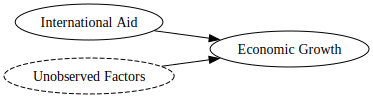

In [13]:
draw_causal_graph(
    edge_list=[("International Aid", "Economic Growth"), 
               ("Unobserved Factors", "Economic Growth")],
    node_props={"Unobserved Factors": {"style": "dashed"}},
    graph_direction="LR",
)

## PyMC Model

Implemet the DAG above as a linear model. Use the form:

$$ \text{Growth}_i = \alpha + \beta \text{Aid}_i + \epsilon_i $$

Assume $\epsilon_i \sim N(0, \sigma)$. So we need priors on $\alpha$, $\beta$, and $\sigma$.

In [14]:
obs_idx = df.index.values
coords = {
    'obs_idx':obs_idx,
    'country':countries,
    'year':years
}

with pm.Model(coords=coords) as naive_model:
    gdp_growth = pm.Data('gdp_growth', df['gdp_growth'], dims=['obs_idx'])
    effective_aid = pm.Data('aid', df['total_aid_gdp'], dims=['obs_idx'])

    alpha = ...
    beta = ...
    sigma = ...

    ## Uncomment me!
    # expected_growth = pm.Deterministic('expected_growth', alpha + beta * effective_aid, dims=['obs_idx'])
    # gdp_growth_hat = pm.Normal('gdp_growth_hat', mu=expected_growth, sigma=sigma, observed=gdp_growth, dims=['obs_idx'])
    # idata = pm.sample()

Uncomment the following cell to look at the estimated effect of growth on aid!

In [15]:
# az.plot_posterior(idata, var_names=['beta']);

# A Slightly Better DAG


The basic idea is that there might be some special qualities of different countries that both cause economic growth, *and* which cause countries to give aid. One example might be internal chaos in a country. If a country has a weak government, with weak rule of law, there might be a lot of internal conflicts and associated human suffering. This would increase aid (to relieve suffering) but reduce growth (because war is bad). But this doesn't imply that higher aid decreases growth!

On the positive side, we might think that certain colonial ties could be benefitial. For example, imagine for the sake of argument that the French legal system is more condusive to economic growth. Colonial ties also induce more aid from the former colonizer, because of a sense of historical connect. Thus, France would give more aid to such a country, and (by assumption) its growth would be higher. But not necessarily because of the aid!

So we want to control for these unobserved country factors. One way is by including **country fixed effects**. Since we observe each country over time, we can absorb country-specific variation with a country effect.

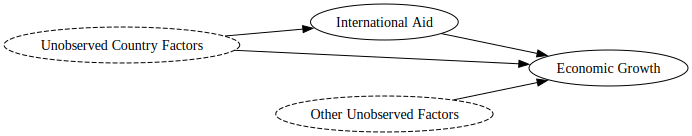

In [16]:
draw_causal_graph(
    edge_list=[("International Aid", "Economic Growth"), 
               ("Unobserved Country Factors", 'Economic Growth'),
               ("Unobserved Country Factors", 'International Aid'),
               ("Other Unobserved Factors", "Economic Growth")],
    node_props={"Other Unobserved Factors": {"style": "dashed"},
                "Unobserved Country Factors": {'style': "dashed"}},
    graph_direction="LR",
)

In [17]:
obs_idx = df.index.values
coords = {
    'obs_idx':obs_idx,
    'country':countries,
    'year':years
}

with pm.Model(coords=coords) as fixed_effect_model:
    gdp_growth = pm.Data('gdp_growth', df['gdp_growth'], dims=['obs_idx'])
    effective_aid = pm.Data('aid', df['total_aid_gdp'], dims=['obs_idx'])
    country_idx_pt = pm.Data('country_idx', country_idx, dims=['obs_idx'])


    # The country effet should have dims = ['country']
    country_effect = ...
    beta = ...
    sigma = ...

    ## Uncomment me!
    # expected_growth = pm.Deterministic('expected_growth', country_effect[country_idx_pt] + beta * effective_aid, dims=['obs_idx'])
    # gdp_growth_hat = pm.Normal('gdp_growth_hat', mu=expected_growth, sigma=sigma, observed=gdp_growth, dims=['obs_idx'])
    # idata_2 = pm.sample()

In [18]:
# az.plot_posterior(idata, var_names=['beta']);